In [1]:
from minio import Minio
import duckdb
import pandas as pd
import numpy as np

### 1. Load Data

In [2]:
ACCESS_KEY = "RkX19daoA4QpeUytwGna"
SECRET_ACCESS_KEY = "jIr2nk8MPaT6xUn5p9qFuSZISg36ykrqXlP2lyjs"
STORAGE_OPTIONS = {
        "key": ACCESS_KEY,
        "secret": SECRET_ACCESS_KEY,
        "endpoint_url": "http://minio-api-svc"}

client = Minio(
    "minio-api-svc",
    access_key=ACCESS_KEY,
    secret_key=SECRET_ACCESS_KEY,
    secure=False
)
connection = duckdb.connect()
connection.execute("INSTALL httpfs")
connection.execute("LOAD httpfs")
connection.execute("SET s3_region='us-east-1'")
connection.execute("SET s3_access_key_id='KhjA5yMeOPzDWDyh'")
connection.execute("SET s3_secret_access_key='PTzHBYNc1HmO3TNdKN3IjUIJx3Q5VS5m'")
connection.execute("SET s3_endpoint='minio-api-svc';")
connection.execute("SET s3_use_ssl=false")
connection.execute("SET s3_url_style=path")


In [3]:
df = pd.read_parquet("data_labeled_feb_7_2024.parquet")

In [4]:
bucket_name_images = "images-october"

In [5]:
df.columns

Index(['id', 'image_path', 'title', 'descriptions', 'negative_keywords',
       'animal_original', 'relevant', 'category', 'price', 'currency',
       'description', 'domain', 'image', 'label_product', 'product',
       'retrieved', 'score_product', 'url', 'pred_text_model', 'seller',
       'location', 'loc_name', 'country', 'lat', 'lon', 'multi_model_pred',
       'final_label', 'match', 'animal_name', 'expert_label'],
      dtype='object')

In [6]:
df['title'][5]

'JOINTS OF THE Upper Extremities Anatomical Chart by Anatomical Chart Company (En $20.03 - PicClick'

In [7]:
# df = pd.read_csv("data_labeled_feb_7_2024.csv")
df["path"] = df["image_path"]
df["label"] = np.where(df.relevant == "animal origin", 1, 0)
df = df.dropna(subset = ["title"])

### 2. Initialize Model

In [8]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

/home/jovyan/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
classifier(sequence_to_classify, candidate_labels)

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.9938650727272034, 0.003273802110925317, 0.002861041808500886]}

In [10]:
df = df.dropna(subset = ["description"]).reset_index()

In [11]:
from tqdm import tqdm

In [28]:
candidate_labels = ['non-animal-derived product', 'direct animal-derived product']
y_pred = []

for i in tqdm(range(len(df))):
    results = classifier(df['description'][i], candidate_labels)
    class_idx = np.argmax(results['labels'])
    y_pred.append(class_idx)

100%|██████████| 1736/1736 [14:30<00:00,  1.99it/s]


In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_true = df['expert_label']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)

print(f"Precision: {recall} Recall: {precision}, accuracy: {accuracy}, f1_score: {f1score}")

Precision: 0.8163265306122449 Recall: 0.4994797086368366, accuracy: 0.6607142857142857, f1_score: 0.6197546804389928


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_confusion_matrix(y_true, y_pred):
    cf_matrix=confusion_matrix(y_true, y_pred)
    labels = [['True Negative', 'False Positive'],['False Negative', 'True Positive']]

    sns.heatmap(cf_matrix, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
    sns.heatmap(cf_matrix, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Display the plot
    plt.show()

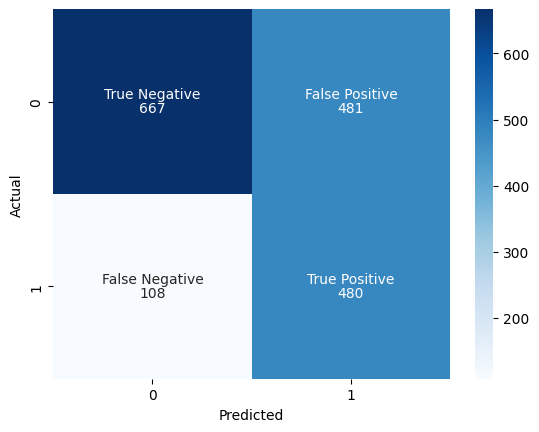

In [31]:
visualize_confusion_matrix(y_true, y_pred)

In [8]:
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torchvision.transforms import transforms
import torch.nn as nn
import torch
from transformers import BertModel, RobertaModel, DistilBertModel
from torchvision.models import resnet50
from torch import cuda
from PIL import Image
import time
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torchvision import models
import torch.nn.functional as F

/home/jovyan/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from io import BytesIO

In [10]:
# We will first prepare the dataset for inference
class InferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, transform=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['title']
        img_path = row['path']
        
        # Processing text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        # GETTING DATA FROM MINIO
        object_name = img_path
        image_data = client.get_object(bucket_name_images, object_name)
        image_bytes = image_data.read()
        image = Image.open(BytesIO(image_bytes)).convert("RGB")
        
        # Processing images
        # image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image
        }


In [11]:
# Combine text fields
# df['path'] = "local_images/" + df['image_path']

In [12]:
# Constants
MAX_LEN = 128
BATCH_SIZE = 16

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Prepare dataset and dataloader for inference
inference_dataset = InferenceDataset(
    dataframe=df,
    tokenizer=tokenizer,  
    max_len=MAX_LEN,
    transform=transform
)

inference_dataloader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
text = DistilBertModel.from_pretrained('distilbert-base-uncased')

img = models.efficientnet_v2_m(pretrained=True)

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, text_dim, image_dim, num_heads, hidden_dim, output_dim):
        super(MultiHeadCrossAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        # These linear layers project the inputs to multiple heads
        self.text_query = nn.Linear(text_dim, hidden_dim, bias=False)
        self.text_key = nn.Linear(text_dim, hidden_dim, bias=False)
        self.text_value = nn.Linear(text_dim, hidden_dim, bias=False)

        self.image_query = nn.Linear(image_dim, hidden_dim, bias=False)
        self.image_key = nn.Linear(image_dim, hidden_dim, bias=False)
        self.image_value = nn.Linear(image_dim, hidden_dim, bias=False)

        # Final projection layer
        self.out_proj = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, text_features, image_features):
        Q_text = self.text_query(text_features)
        K_text = self.text_key(text_features)
        V_text = self.text_value(text_features)

        Q_image = self.image_query(image_features)
        K_image = self.image_key(image_features)
        V_image = self.image_value(image_features)

        # Split the hidden dimension into num_heads
        Q_text = Q_text.view(Q_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        K_text = K_text.view(K_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        V_text = V_text.view(V_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        Q_image = Q_image.view(Q_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        K_image = K_image.view(K_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        V_image = V_image.view(V_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate the attention scores
        attn_scores_text_image = torch.matmul(Q_text, K_image.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attn_scores_image_text = torch.matmul(Q_image, K_text.transpose(-1, -2)) / (self.head_dim ** 0.5)

        # Normalize scores
        attn_probs_text_image = F.softmax(attn_scores_text_image, dim=-1)
        attn_probs_image_text = F.softmax(attn_scores_image_text, dim=-1)

        # Apply attention
        attn_output_text_image = torch.matmul(attn_probs_text_image, V_image)
        attn_output_image_text = torch.matmul(attn_probs_image_text, V_text)

        # Concatenate the results across the heads
        attn_output_text_image = attn_output_text_image.transpose(1, 2).contiguous().view(text_features.size(0), -1)
        attn_output_image_text = attn_output_image_text.transpose(1, 2).contiguous().view(image_features.size(0), -1)

        # Project to output dimension
        output_text_image = self.out_proj(attn_output_text_image)
        output_image_text = self.out_proj(attn_output_image_text)

        return output_text_image, output_image_text


class MultiModalModel(nn.Module):
            def __init__(self, num_labels):
                super(MultiModalModel, self).__init__()

                # Load pre-trained models
                self.bert = text
                self.resnet = img

                # Remove the final classification layer of ResNet
                self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
                self.mhca = MultiHeadCrossAttention(text_dim=768, image_dim=1280, num_heads=4, hidden_dim=512, output_dim=2048)
                
                
                self.classifier = nn.Sequential(
                    nn.Linear(2816, 512), 
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(512, num_labels)
                )

            def forward(self, input_ids, attention_mask, image):
                # Forward pass through BERT
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
                text_features = outputs['last_hidden_state'][:, 0, :]  # CLS token output as text feature
                
                # Forward pass through ResNet
                image_features = self.resnet(image)
                image_features = image_features.view(image_features.size(0), -1)  # Flatten the output
                
                if text_features.dim() == 2:
                    text_features = text_features.unsqueeze(1)
                if image_features.dim() == 2:
                    image_features = image_features.unsqueeze(1)
                
                attended_text, attended_image = self.mhca(text_features, image_features)
                
                attended_text = attended_text.squeeze(1)  # shape: [16, 768]
                attended_image = attended_image.squeeze(1) # shape: [16, 2048]

                self.image_projection = torch.nn.Linear(2048, 768).to(device)
                attended_image = self.image_projection(attended_image)
                combined_features = torch.cat((attended_text, attended_image), dim=-1)

                logits = self.classifier(combined_features)

                return logits



/home/jovyan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import urllib3, socket
from urllib3.connection import HTTPConnection

HTTPConnection.default_socket_options = ( 
    HTTPConnection.default_socket_options + [
    (socket.SOL_SOCKET, socket.SO_SNDBUF, 1000000), #1MB in byte
    (socket.SOL_SOCKET, socket.SO_RCVBUF, 1000000)
])

In [15]:
# Function to run inference
def run_inference(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions


In [16]:
# Initialize an empty model
loaded_model = MultiModalModel(num_labels=2)

# Load the state dictionary
# client.fget_object("multimodal", "model.pth",'./model.pth')
model_load_path = './model.pth'

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model weights
if device == torch.device('cpu'):
    loaded_model.load_state_dict(torch.load(model_load_path, map_location=device), strict=False)
else:
    loaded_model.load_state_dict(torch.load(model_load_path), strict=False)

# Move model to evaluation mode and to the device
loaded_model.eval()
loaded_model = loaded_model.to(device)

start_time = time.time()

# Get the predictions
predictions = run_inference(loaded_model, inference_dataloader, device)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Inference took {elapsed_time:.2f} seconds")


# Add predictions to the dataframe
df['predicted_label'] = predictions

Inference took 166.58 seconds


In [17]:
df.head()

,id,image_path,title,descriptions,negative_keywords,animal_original,relevant,category,price,currency,...,lat,lon,multi_model_pred,final_label,match,animal_name,expert_label,path,label,predicted_label
0,0016dc48-0838-4d05-9d9d-48240782a149,0016dc48-0838-4d05-9d9d-48240782a149.png,Straußenei geblasen Struthio Camelus auf Stand...,egg,None,Ostrich,animal origin,None,141.51,EUR,...,44.25029,-85.50033,1.0,1.0,Struthio camelus,Struthio camelus,1,0016dc48-0838-4d05-9d9d-48240782a149.png,1,0
1,004602cf-360e-4a71-8ac2-836462c00206,004602cf-360e-4a71-8ac2-836462c00206.png,CIONDOLO DENTE DI SQUALO fossilizzato 1 & 1/8 ...,"shark Tooth, shark Tooth, shark Tooth",None,Sand tiger shark,animal origin,None,23.58,EUR,...,27.18248,-82.36498,1.0,1.0,None,None,1,004602cf-360e-4a71-8ac2-836462c00206.png,1,1
2,00797dee-651c-4b51-8d7a-5c5ecb1782d4,00797dee-651c-4b51-8d7a-5c5ecb1782d4.png,PENDENTIF DENT DE REQUIN fossilisé 1 pouce SAB...,shark Tooth,None,Sand tiger shark,animal origin,None,18.86,EUR,...,27.18248,-82.36498,1.0,1.0,None,None,1,00797dee-651c-4b51-8d7a-5c5ecb1782d4.png,1,1
3,00f3d4bd-ed07-46ad-92d5-1697a7b97d01,00f3d4bd-ed07-46ad-92d5-1697a7b97d01.png,eBay-Home,None,book,None,not animal origin,None,102.55,EUR,...,54.75844,-2.69531,0.0,0.0,None,None,0,00f3d4bd-ed07-46ad-92d5-1697a7b97d01.png,0,0
4,010b09ef-87ee-4cd8-b4ca-c229d9ab662b,010b09ef-87ee-4cd8-b4ca-c229d9ab662b.png,18k Gold and Ruby Vintage Filigree Large Cross...,None,jewelry,None,not animal origin,Pendant Necklaces,2400.00,USD,...,40.77427,-73.96981,1.0,1.0,None,None,0,010b09ef-87ee-4cd8-b4ca-c229d9ab662b.png,0,0


In [18]:
## TEST SET

In [51]:
def check_performance(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    cm=confusion_matrix(y_true, y_pred)
    return cm

In [52]:
cf_matrix = check_performance(y_true, y_pred)

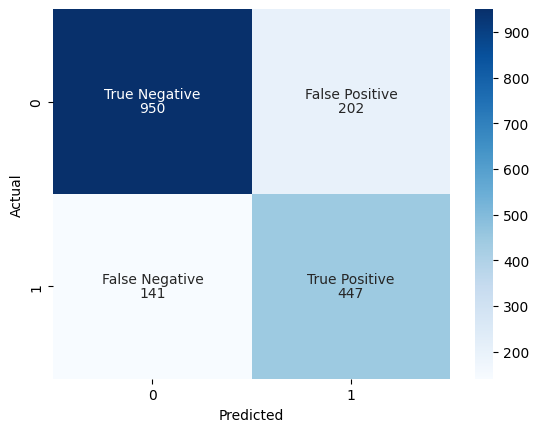

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt


# Create a list of labels for each cell in the confusion matrix
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

# Create the heatmap with labels
# sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
sns.heatmap(cf_matrix, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
sns.heatmap(cf_matrix, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [23]:
precision = precision_score(df["label"], df["predicted_label"])
recall = recall_score(df["label"], df["predicted_label"])
accuracy = accuracy_score(df["label"], df["predicted_label"])
f"Precision: {recall} Recall: {precision}, accuracy: {accuracy}"

'Precision: 0.7602040816326531 Recall: 0.6887519260400616, accuracy: 0.8028735632183908'

In [24]:
## TRAINING SET

In [25]:
cf_matrix = check_performance(df["label"], df["predicted_label"])

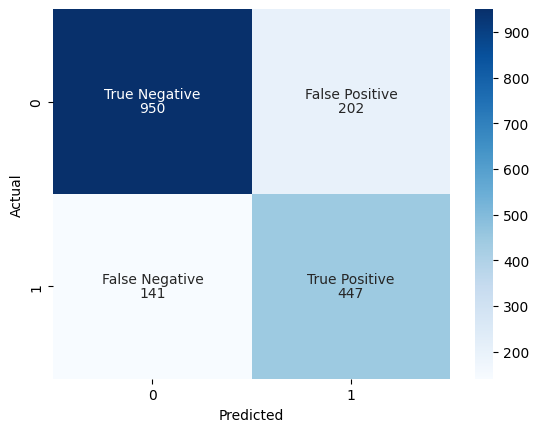

In [26]:

import seaborn as sns
import matplotlib.pyplot as plt


# Create a list of labels for each cell in the confusion matrix
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

# Create the heatmap with labels
# sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
sns.heatmap(cf_matrix, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
sns.heatmap(cf_matrix, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()

In [27]:
precision = precision_score(df["label"], df["predicted_label"])
recall = recall_score(df["label"], df["predicted_label"])
accuracy = accuracy_score(df["label"], df["predicted_label"])
f"Precision: {recall} Recall: {precision}, accuracy: {accuracy}"

'Precision: 0.7602040816326531 Recall: 0.6887519260400616, accuracy: 0.8028735632183908'